In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [3]:
raw_data = pd.read_csv("../data/cars.csv")
raw_data

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4
...,...,...,...,...,...,...,...,...,...
4340,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,S 350
4341,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,535
4342,BMW,8000.0,sedan,194,2.0,Petrol,yes,1985,520
4343,Toyota,14200.0,sedan,31,NaN,Petrol,yes,2014,Corolla


Pré processamento

In [4]:
raw_data.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Determinando as variáveis de interesse

In [5]:
data = raw_data.drop(["Model"], axis=1)

In [6]:
data.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [7]:
data_no_mv = data.dropna(axis=0)

In [8]:
data_no_mv

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
4339,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
4340,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
4341,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999
4342,BMW,8000.0,sedan,194,2.0,Petrol,yes,1985


/tmp/ipykernel_10205/2991907454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv["Price"])


<Axes: xlabel='Price', ylabel='Density'>

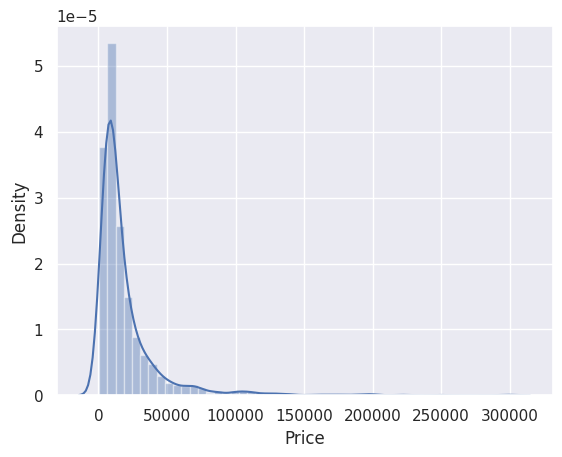

In [9]:
sns.distplot(data_no_mv["Price"])

In [10]:
q = data_no_mv["Price"].quantile(0.99)
data_1 = data_no_mv[data_no_mv["Price"] < q]
data_1.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


/tmp/ipykernel_10205/32400531.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_1["Price"])


<Axes: xlabel='Price', ylabel='Density'>

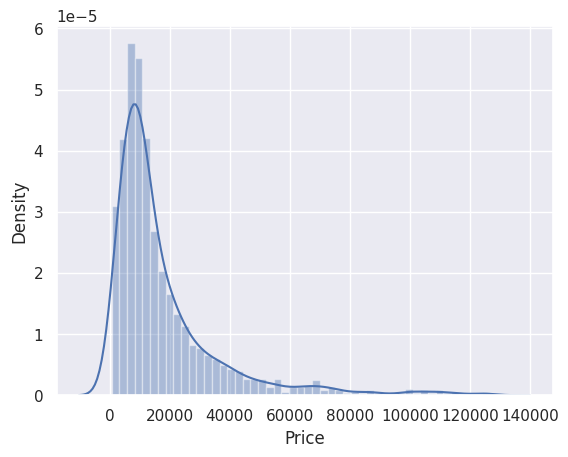

In [11]:
sns.distplot(data_1["Price"])

In [22]:
q = data_1["Mileage"].quantile(0.99)
data_2 = data_1[data_1["Mileage"] < q]
data_2.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3944,3944.000000,3944,3944.000000,3944.000000,3944,3944,3944.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,867,NaN,1511,NaN,NaN,1825,3576,NaN
mean,NaN,17933.880822,NaN,161.484026,2.747612,NaN,NaN,2006.389959
std,NaN,19008.212025,NaN,96.027108,4.980406,NaN,NaN,6.595986
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,7000.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21376.250000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


/tmp/ipykernel_10205/1011256323.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_2["Mileage"])


<Axes: xlabel='Mileage', ylabel='Density'>

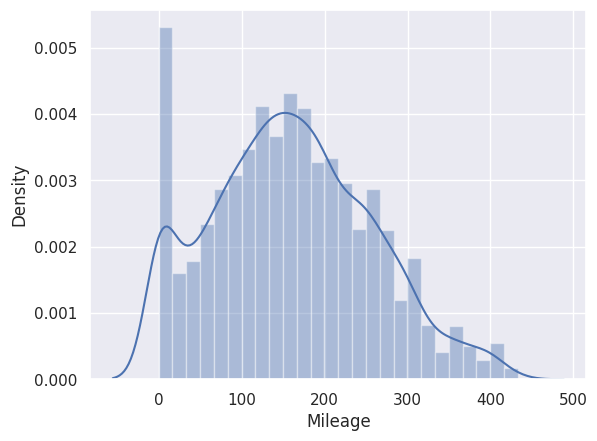

In [13]:
sns.distplot(data_2["Mileage"])

In [23]:
data_3 = data_2[data_2["EngineV"] < 6.5]
data_3.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3921,3921.000000,3921,3921.000000,3921.000000,3921,3921,3921.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,862,NaN,1499,NaN,NaN,1818,3559,NaN
mean,NaN,17988.421311,NaN,161.279776,2.443497,NaN,NaN,2006.406019
std,NaN,19041.658686,NaN,96.068269,0.946198,NaN,NaN,6.595871
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,7000.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21500.000000,NaN,229.000000,3.000000,NaN,NaN,2012.000000


/tmp/ipykernel_10205/1518513432.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_3["EngineV"])


<Axes: xlabel='EngineV', ylabel='Density'>

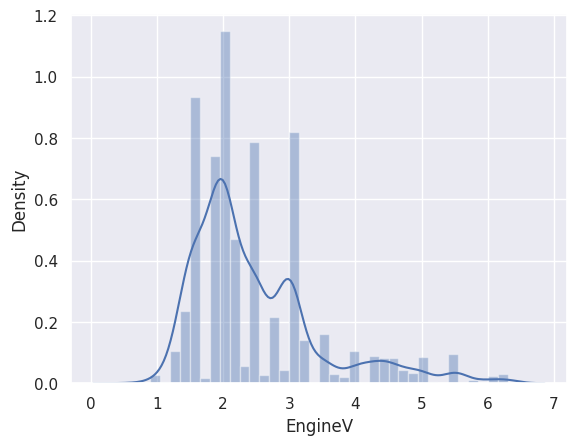

In [15]:
sns.distplot(data_3["EngineV"])

In [24]:
q = data_3["Year"].quantile(0.01)
data_4 = data_3[data_3["Year"] > q]

/tmp/ipykernel_10205/3005889727.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_4["Year"])


<Axes: xlabel='Year', ylabel='Density'>

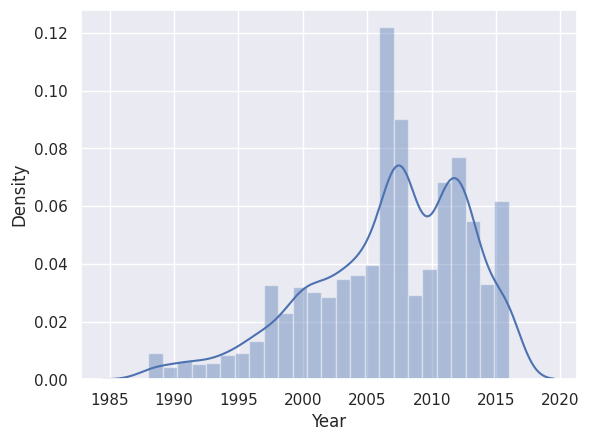

In [25]:
sns.distplot(data_4["Year"])

In [26]:
data_cleaned = data_4.reset_index(drop=True)

In [27]:
data_cleaned.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


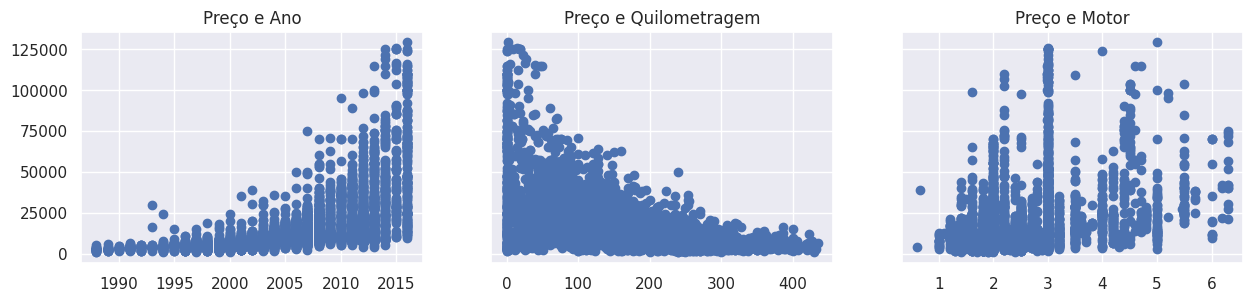

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned["Year"], data_cleaned["Price"])
ax1.set_title("Preço e Ano")
ax2.scatter(data_cleaned["Mileage"], data_cleaned["Price"])
ax2.set_title("Preço e Quilometragem")
ax3.scatter(data_cleaned["EngineV"], data_cleaned["Price"])
ax3.set_title("Preço e Motor")

plt.show()

In [29]:
log_price = np.log(data_cleaned["Price"])
data_cleaned["log_price"] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656
...,...,...,...,...,...,...,...,...,...
3862,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008,9.350102
3863,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014,9.792556
3864,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,11.736069
3865,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,8.779557


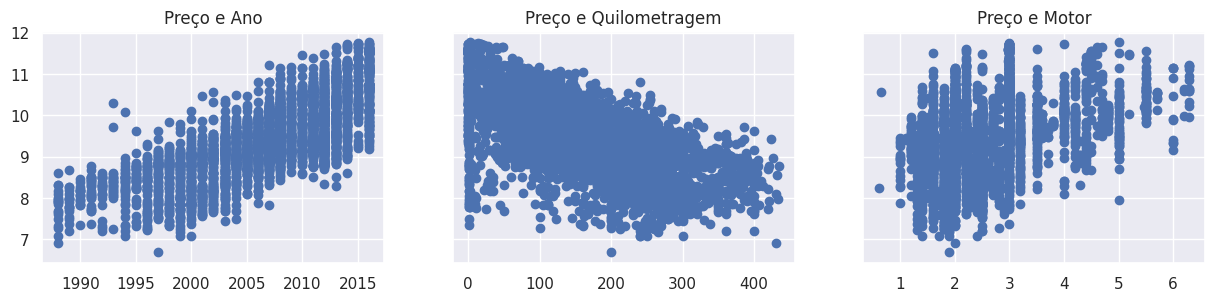

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned["Year"], data_cleaned["log_price"])
ax1.set_title("Preço e Ano")
ax2.scatter(data_cleaned["Mileage"], data_cleaned["log_price"])
ax2.set_title("Preço e Quilometragem")
ax3.scatter(data_cleaned["EngineV"], data_cleaned["log_price"])
ax3.set_title("Preço e Motor")

plt.show()

In [31]:
data_cleaned = data_cleaned.drop(["Price"], axis=1)

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_cleaned[["Mileage", "Year", "EngineV"]]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns


In [ ]:
# VIF = 1: sem multicolinearidade
# 1 < VIF < 5 ok
# 10 < VIF inaceitável
vif

,VIF,features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


In [34]:
data_no_multicollinearity = data_cleaned.drop(["Year"], axis=1)

In [35]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [36]:
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1,427,2.9,8.974618,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
2,358,5.0,9.495519,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
3,240,4.2,10.043249,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,120,2.0,9.814656,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True


In [37]:
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [39]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [40]:
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1,8.974618,427,2.9,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
2,9.495519,358,5.0,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
3,10.043249,240,4.2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,9.814656,120,2.0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True


In [41]:
target = data_preprocessed["log_price"]
inputs = data_preprocessed.drop(["log_price"], axis=1)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)


,copy,True
,with_mean,True
,with_std,True


In [45]:
inputs_scaled = scaler.transform(inputs)

In [46]:
inputs_scaled

array([[ 1.2179077 , -0.47452478,  2.27971827, ..., -0.16209221,
         1.33267512,  0.32137366],
       [ 2.78660201,  0.47359854, -0.43865069, ..., -0.16209221,
        -0.75037043,  0.32137366],
       [ 2.06500263,  2.68588629, -0.43865069, ..., -0.16209221,
        -0.75037043,  0.32137366],
       ...,
       [-1.58482613,  0.57894557, -0.43865069, ..., -0.16209221,
        -0.75037043,  0.32137366],
       [-1.66848982,  1.10568075,  2.27971827, ..., -0.16209221,
         1.33267512,  0.32137366],
       [-0.38216049, -0.47452478, -0.43865069, ..., -0.16209221,
        -0.75037043,  0.32137366]], shape=(3867, 17))

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, target, test_size=0.2, random_state=365)


In [51]:
reg = LinearRegression()
reg.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [52]:
y_hat = reg.predict(X_train)

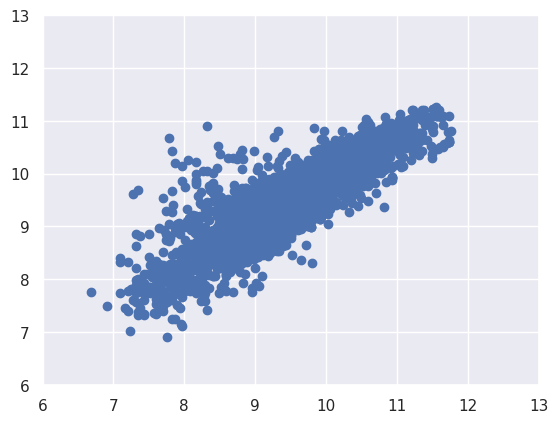

In [54]:
plt.scatter(y_train, y_hat)
plt.xlim(6, 13)
plt.ylim(6, 13)
plt.show()

/tmp/ipykernel_10205/673607322.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train - y_hat)


<Axes: xlabel='log_price', ylabel='Density'>

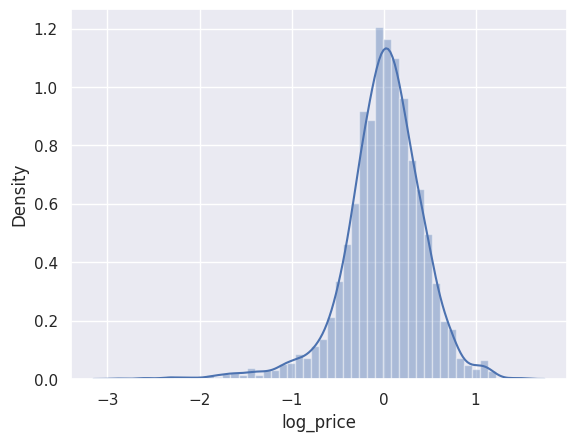

In [56]:
sns.distplot(y_train - y_hat)

In [57]:
reg.score(X_train, y_train)

0.744996578792662

In [58]:
reg.intercept_

np.float64(9.415239458021299)

In [59]:
reg.coef_

array([-0.44871341,  0.20903483,  0.0142496 ,  0.01288174, -0.14055166,
       -0.17990912, -0.06054988, -0.08992433, -0.1454692 , -0.10144383,
       -0.20062984, -0.12988747, -0.16859669, -0.12149035, -0.03336798,
       -0.14690868,  0.32047333])

In [60]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=["Features"])
reg_summary["Weights"] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.448713
1,EngineV,0.209035
2,Brand_BMW,0.014250
3,Brand_Mercedes-Benz,0.012882
4,Brand_Mitsubishi,-0.140552
5,Brand_Renault,-0.179909
6,Brand_Toyota,-0.060550
7,Brand_Volkswagen,-0.089924
8,Body_hatch,-0.145469
9,Body_other,-0.101444


In [65]:
data_cleaned["Engine Type"].unique()

array(['Petrol', 'Diesel', 'Gas', 'Other'], dtype=object)

In [66]:
y_hat_test = reg.predict(X_test)

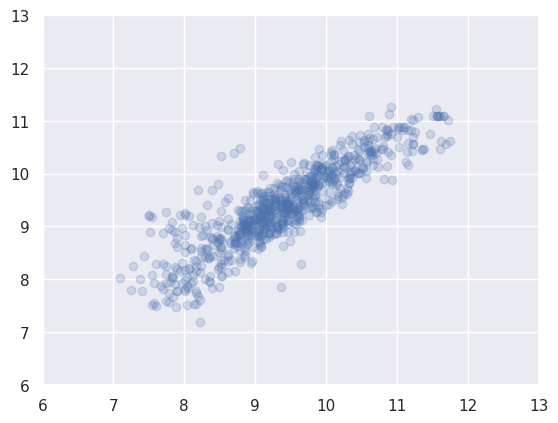

In [68]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlim(6, 13)
plt.ylim(6, 13)
plt.show()

In [70]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=["Previsões"])
df_pf.head()

,Previsões
0,10685.501696
1,3499.255242
2,7553.285218
3,7463.963017
4,11353.490075


In [71]:
df_pf["Target"] = np.exp(y_test)
df_pf.head()

,Previsões,Target
0,10685.501696,NaN
1,3499.255242,7900.0
2,7553.285218,NaN
3,7463.963017,NaN
4,11353.490075,NaN


In [72]:
y_test = y_test.reset_index(drop=True)

In [73]:
df_pf["Target"] = np.exp(y_test)
df_pf.head()

,Previsões,Target
0,10685.501696,2300.0
1,3499.255242,2800.0
2,7553.285218,2500.0
3,7463.963017,6400.0
4,11353.490075,9150.0


In [74]:
df_pf["Resíduos"] = df_pf["Target"] - df_pf["Previsões"]

In [76]:
df_pf["Diferença %"] = np.absolute(df_pf["Resíduos"]/df_pf["Target"] * 100)

In [78]:
df_pf.describe()

,Previsões,Target,Resíduos,Diferença %
count,774.000000,774.000000,774.000000,774.000000
mean,15946.760167,18165.817106,2219.056939,36.256693
std,13133.197604,19967.858908,10871.218143,55.066507
min,1320.562768,1200.000000,-29456.498331,0.062794
25%,7413.644234,6900.000000,-2044.191251,12.108022
50%,11568.168859,11600.000000,142.518577,23.467728
75%,20162.408805,20500.000000,3147.343497,39.563570
max,77403.055224,126000.000000,85106.162329,512.688080


In [ ]:
pd.options.display.max_rows = 999
pd.set_option("display.float_format", lambda x: "%.2f" % x)
df_pf.sort_values(by=["Diferença %"])

,Previsões,Target,Resíduos,Diferença %
698,%.2f % x,%.2f % x,%.2f % x,%.2f % x
742,%.2f % x,%.2f % x,%.2f % x,%.2f % x
60,%.2f % x,%.2f % x,%.2f % x,%.2f % x
110,%.2f % x,%.2f % x,%.2f % x,%.2f % x
367,%.2f % x,%.2f % x,%.2f % x,%.2f % x
369,%.2f % x,%.2f % x,%.2f % x,%.2f % x
769,%.2f % x,%.2f % x,%.2f % x,%.2f % x
272,%.2f % x,%.2f % x,%.2f % x,%.2f % x
714,%.2f % x,%.2f % x,%.2f % x,%.2f % x
630,%.2f % x,%.2f % x,%.2f % x,%.2f % x
